# Modules

In [375]:
%matplotlib inline
import glob, os, sys, timeit
import numpy as np
import re
import sys
import ast
import pandas as pd
import random as r
import bisect
from scipy.stats import truncnorm
import copy

%load_ext autoreload
# updates pyqsofit.py
%autoreload 2

sys.path.append('../')
from pyqsofit.PyQSOFit import QSOFit

from astropy.io import fits
from astropy.table import Table
import matplotlib.pyplot as plt
import warnings

from pysynphot import observation
from pysynphot import spectrum

warnings.filterwarnings("ignore")

QSOFit.set_mpl_style()

# Show the versions so we know what works
import astropy
import lmfit
import pyqsofit

print(astropy.__version__)
print(lmfit.__version__)
print(pyqsofit.__version__)

import emcee  # optional, for MCMC

print(emcee.__version__)

print(pyqsofit.__path__) # Check path

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
5.3.4
1.2.2
2.1.6
3.1.4
['/Users/joel/anaconda3/lib/python3.11/site-packages/pyqsofit']


# Read Spectrum

Warning, 7 of 6581 bins contained negative fluxes; they have been set to zero.
Warning, 7 of 6581 bins contained negative fluxes; they have been set to zero.


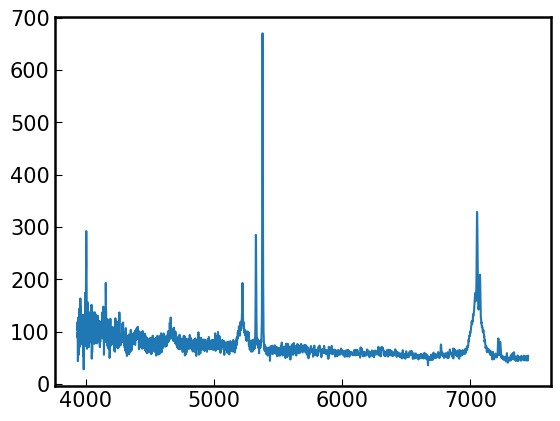

In [376]:
# Prepare data for SDSS
# Rebin_spec
def rebin_spec(wave, specin, wavnew):
    spec = spectrum.ArraySourceSpectrum(wave=wave, flux=specin)
    f = np.ones(len(wave))
    filt = spectrum.ArraySpectralElement(wave, f, waveunits='angstrom')
    obs = observation.Observation(spec, filt, binset=wavnew, force='taper')
    return obs.binflux

# Function that reads in the data from txt. files
def readTxt(file_path, errors):
    # Initialize empty lists to be returned
    values1 = []
    values2 = []
    err_values = []
    
    with open(file_path, 'r') as file:
        for line in file:
            
            # Check the row begins with a number - not holding a column title
            if line[0].isnumeric():
            
                # Split each line into separate values separated by one or more space or commas
                values = re.split(r'[\s,]+', line.strip())
                
                # Convert the values to floats and append them to the respective lists
                if len(values) > 1:
                    values1.append(float(values[0]))
                    values2.append(float(values[1]))
                    if errors == True:
                        err_values.append(abs(float(values[2])))
    
    if errors == True:
        return(np.array(values1), np.array(values2), np.array(err_values))
    else:
        return(np.array(values1), np.array(values2))

# Function calculating rest frame wavelength from host redshift
def restFrameWavelength(obs_wavelength, redshift): # takes list of measured wavelengths
    rest_wavelength = []
    for n in range(len(obs_wavelength)):
        rest_wavelength.append(obs_wavelength[n]/(redshift+1))
    return(np.array(rest_wavelength))


path_out = os.path.join(pyqsofit.__path__[0], '../', '/Users/joel/Library/CloudStorage/OneDrive-UniversityofSouthampton/Post Grad/ZTF18abuamgo_CLAGN_Project/ZTF18abuamgo_Analysis')


# Scale factors for spectra matching 2024 integrated [O III]5007 then 1e17 for SDSS format (PyQSOFit req.)
#sf_04 = 7.230792282954545e-19 * 1e17
sf_04 = 0.06670665803414269
sf_22 = 2.8414225252601 * 1e17
sf_24 = 1e17

'''
# 2004
# Required
file_path_2004 = '/Users/joel/Library/CloudStorage/OneDrive-UniversityofSouthampton/Post Grad/ZTF18abuamgo_CLAGN_Project/Data/6df_spectra/6dFJ0245455-030450-S-VR-j2009.txt'
wave, flux = readTxt(file_path_2004, False)
err = flux*0.1
z = 0.074550  # Redshift

# These steps here is how you turn any spectrum into a sdss spectrum - rebin_spec is a very handy function
wavenew = np.arange(wave[0], wave[-1], 10 ** 1e-4)
#flux = rebin_spec(wave, flux, wavenew) * 0.024643971103449368*3.145 # Rescaled to 2022 then the 3 from 2022 to 2024
#err = rebin_spec(wave, err, wavenew) * 0.024643971103449368*3.145
flux = rebin_spec(wave, flux, wavenew) * sf_04
err = rebin_spec(wave, err, wavenew) * sf_04
lam = wavenew
indices_to_remove = np.where((lam < 3960) | ((lam > 5568) & (lam < 5608)) | (lam > 7450))[0] # 2004 cut off low redshift end (goes to 0) and above 6930AA in rest wav   5588AA 5200 rest
'''
'''
# 2022
file_path_2022 = '/Users/joel/Library/CloudStorage/OneDrive-UniversityofSouthampton/Post Grad/ZTF18abuamgo_CLAGN_Project/Data/10JYSElqi_spectra/10JYSElqi_gr4_2022-09-09T05h46h03s_final_red.txt'
wave, flux, err = readTxt(file_path_2022, True)
z = 0.074550  # Redshift

# These steps here is how you turn any spectrum into a sdss spectrum - rebin_spec is a very handy function
wavenew = np.arange(wave[0], wave[-1], 10 ** 1e-4)
#flux = rebin_spec(wave, flux, wavenew) * 3.145 * 1e17 # scale 2022 to 2024 and SDSS units of flux in terms of 1e-17
#err = rebin_spec(wave, err, wavenew) * 3.145 * 1e17
flux = rebin_spec(wave, flux, wavenew) * sf_22
err = rebin_spec(wave, err, wavenew) * sf_22
lam = wavenew
indices_to_remove = np.where((lam < 3933) | ((lam > 5271) & (lam < 5283)) | (lam > 7450))[0] # 2022 corrected for redshift: 3660 (red end), ~4905-4915, 6930 (blue end)
'''
#'''
# 2024
file_path_2024 = '/Users/joel/Library/CloudStorage/OneDrive-UniversityofSouthampton/Post Grad/ZTF18abuamgo_CLAGN_Project/Data/10JYSElqi_spectra/28_August_2024_spec/10JYSElqi_WiFeS_20240828.csv'
wave, flux = readTxt(file_path_2024, False)
err = flux*0.1
z = 0.074550  # Redshift

# These steps here is how you turn any spectrum into a sdss spectrum - rebin_spec is a very handy function
wavenew = np.arange(wave[0], wave[-1], 10 ** 1e-4)
#flux = rebin_spec(wave, flux, wavenew) * 1e17 # SDSS units of flux in terms of 1e-17
#err = flux*0.1
flux = rebin_spec(wave, flux, wavenew) * sf_24
err = rebin_spec(wave, err, wavenew) * sf_24
lam = wavenew
indices_to_remove = np.where((lam < 3933) | (lam > 7450))[0] # 2024 corrected for redshift: 3660 (red end), 6930 (blue end)
#'''

# Apply wave_mask here since PyQSOFit doesn't work with wave_mask at the moment.
flux = np.delete(flux, indices_to_remove)
err = np.delete(err, indices_to_remove)
lam = np.delete(lam, indices_to_remove)

# Optional
ra = 41.43958  # RA
dec = -3.08047  # DEC

plt.plot(lam, flux)
plt.show()

np.savez('/Users/joel/Library/CloudStorage/OneDrive-UniversityofSouthampton/Post Grad/ZTF18abuamgo_CLAGN_Project/ZTF18abuamgo_Analysis/rebinned_2024_for_BP_plot.npz', lam = lam, flux = flux)

In [377]:
2.827984/0.9952704938668459

2.8414225252601

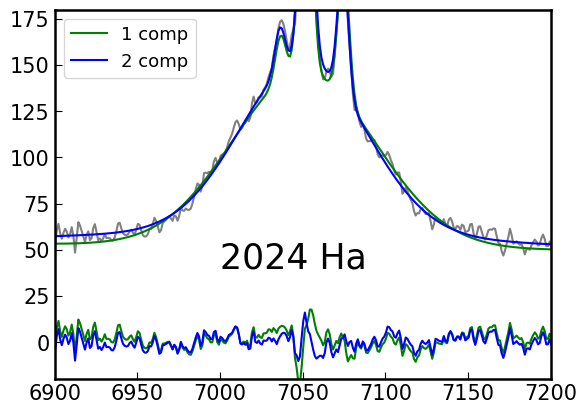

In [378]:
# Check 1 vs 2 Ha Hb broad components
model_file = np.load('/Users/joel/Library/CloudStorage/OneDrive-UniversityofSouthampton/Post Grad/ZTF18abuamgo_CLAGN_Project/ZTF18abuamgo_Analysis/PyQSOFit Spectra Models/2024_ngauss1_br_balmer_untied.npz')
model = model_file['model']
residuals = model_file['resid']
model_file2 = np.load('/Users/joel/Library/CloudStorage/OneDrive-UniversityofSouthampton/Post Grad/ZTF18abuamgo_CLAGN_Project/ZTF18abuamgo_Analysis/PyQSOFit Spectra Models/2024_ngauss2.npz')
model2 = model_file2['model']
residuals2 = model_file2['resid']

plt.plot(lam, flux, color='grey')

plt.plot(lam, model, color='green', label='1 comp')
plt.plot(lam, residuals, color='green')

plt.plot(lam, model2, color='blue', label='2 comp')
plt.plot(lam, residuals2, color='blue')

#plt.xlim(5125, 5350) # Hb
#plt.ylim(-25, 140) # Hb
plt.xlim(6900, 7200) # Ha
plt.ylim(-20, 180) # Ha

#plt.text(5200, 40, '2004 Hb', fontsize=25)
plt.text(7000, 40, '2024 Ha', fontsize=25)

plt.legend(fontsize=13, loc='upper left')
plt.show()

# Model Parameters

In [379]:
path_ex = '.' #os.path.join(pyqsofit.__path__[0], '..', 'example')

# create a header
hdr0 = fits.Header()
hdr0['Author'] = 'Joel Carpenter'
primary_hdu = fits.PrimaryHDU(header=hdr0)

In [384]:
"""
In this table, we specify the priors / initial conditions and boundaries for the line fitting parameters.
"""
#'''
# 2024 All lines included and tied as much as possible
line_priors = np.rec.array([
    #lambda, compname,   minwav,  maxwav, linename, ngauss, inisca, minsca, maxsca,     inisig, minsig, maxsig,       voff, vindex, windex, findex, fvalue, vary
    (6564.61, 'All',        3660, 6760,     'Ha_br', 1,         137.1, 0.0, 1e10,       6.4e-3, 0.004, 0.05,          0.015, 2,   0,   0, 0.05, 1), # Ha
    (6564.61, 'All',        3660, 6760,     'Ha_na', 1,         138.3, 0.0, 1e10,       8.9e-4, 5e-5, 0.00169,        0.01, 3,    2,   0, 0.002, 1),
    (6549.85, 'All',        3660, 6760,     'NII6549', 1,       18.50, 0.0, 1e10,       1.2e-3, 2.3e-4, 0.00169,      5e-3, 1,    1,   1, 0.001, 1),
    (6585.28, 'All',        3660, 6760,     'NII6585', 1,       55.49, 0.0, 1e10,       1.2e-3, 2.3e-4, 0.00169,      5e-3, 1,    1,   1, 0.003, 1), # 1-3 flux ratio
    (6718.29, 'All',        3660, 6760,     'SII6718', 1,       16.71, 0.0, 1e10,       1.2e-3, 2.3e-4, 0.00169,      5e-3, 1,    1,   2, 0.001, 1),
    (6732.67, 'All',        3660, 6760,     'SII6732', 1,       16.71, 0.0, 1e10,       1.2e-3, 2.3e-4, 0.00169,      5e-3, 1,    1,   2, 0.001, 1),
    
    (6300.30, 'All',        3660, 6760,     'OI6300', 1,        14.73, 0.0, 1e10,       1.2e-3, 2.3e-4, 0.00169,      5e-3, 1,    1,   0, 0.001, 1), # OI
    
    (5875.62, 'All',        3660, 6760,     'HeI5875_br', 1,    8.881, 0.0, 1e10,       2.0e-2, 5e-4, 2e-2,           5e-3, 0,    3,   0, 0.001, 1), # HeI
    (5875.62, 'All',        3660, 6760,     'HeI5875_na', 1,    8.881, 0, 30,           1.2e-3, 3.333e-4, 0.00169,    0.01, 1,    1,   0, 0.001, 1),

    (4862.68, 'All',        3660, 6760,     'Hb_br', 1,         55.17, 0.0, 1e10,       7.6e-3, 0.004, 0.05,          0.01, 2,    0,   0, 0.01, 1), # Hb
    (4862.68, 'All',        3660, 6760,     'Hb_na', 1,         36.03, 0.0, 1e10,       1.2e-3, 5e-5, 0.00169,        0.01, 3,    2,   0, 0.002, 1),
    (4960.30, 'All',        3660, 6760,     'OIII4959c', 1,     102.4, 0.0, 1e10,       1.2e-3, 1e-5, 0.00169,        0.01, 4,    5,   6, 0.02, 1),
    (5008.24, 'All',        3660, 6760,     'OIII5007c', 1,     307.1, 0.0, 1e10,       1.2e-3, 1e-5, 0.00169,        0.01, 4,    5,   6, 0.06, 1), # 1-3 flux ratio
    #(4960.30, 'All',        3660, 6760,     'OIII4959w', 1,     19.57, 0.0, 1e10,       2.6e-3, 0.004, 0.01,          0.01, 5,    7,   0, 0.001, 1),
    #(5008.24, 'All',        3660, 6760,     'OIII5007w', 1,     15.48, 0.0, 1e10,       2.6e-3, 0.004, 0.01,          0.01, 5,    7,   0, 0.002, 1),
    (4687.02, 'All',        3660, 6760,     'HeII4687_br', 1,   14.35, 0.0, 1e10,       1.1e-2, 5e-5,  0.05,          0.005, 0,   0,   0, 0.001, 1),
    (4687.02, 'All',        3660, 6760,     'HeII4687_na', 1,   5.956, 0.0, 1e10,       1.2e-3, 2.3e-4, 0.00169,      0.005, 1,   1,   0, 0.001, 1),
    
    (4341.68, 'All',        3660, 6760,     'Hg_br', 1,         29.56, 0, 40,           6.8e-3, 0.002, 0.05,          0.01, 2,    6,   0, 0.001, 1), # Hg
    (4341.68, 'All',        3660, 6760,     'Hg_na', 1,         29.56, 0, 40,           1.2e-3, 5e-5, 0.00169,        0.01, 3,    2,   0, 0.001, 1),
    
    (4101.74, 'All',        3660, 6760,     'Hd_br', 1,         15.27, 0, 30,           6.0e-3, 0.004, 0.05,          0.01, 2,    6,   0, 0.001, 1), # Hd
    (4101.74, 'All',        3660, 6760,     'Hd_na', 1,         15.27, 0, 30,           1.2e-3, 5e-5, 0.00169,        0.01, 3,    2,   0, 0.001, 1),

    (3970.08, 'All',        3660, 6760,     'Hep_br', 1,        12.31, 0, 30,           4.0e-3, 0.004, 0.05,          0.01, 2,    6,   0, 0.001, 1), # Hep
    (3970.08, 'All',        3660, 6760,     'Hep_na', 1,        10.57, 0, 30,           1.2e-3, 5e-5, 0.00169,        0.01, 3,    2,   0, 0.001, 1),
    
    (3868.76, 'All',        3660, 6760,     'NeIII3868', 1,     51.49, 0, 150,          1.2e-3, 1e-5, 0.0025,         0.01, 0,    1,   0, 0.001, 1), # NeIII
    
    (3728.48, 'All',        3660, 6760,     'OII3728', 1,       91.21, -10, 150,        1.2e-3, 1e-5, 0.0025,         0.01, 0,    0,   0, 0.001, 1), # OII
    ],

    formats='float32,    a20,  float32, float32,      a20,  int32, float32, float32, float32, float32, float32, float32, float32,   int32,  int32,  int32, float32, int32',
    names=' lambda, compname,   minwav,  maxwav, linename, ngauss,  inisca,  minsca,  maxsca,  inisig,  minsig,  maxsig,    voff,  vindex, windex, findex,  fvalue,  vary')
#'''
'''
# 2004, 2022 All lines included and tied as much as possible - except Balmer untied
line_priors = np.rec.array([
    #lambda, compname,   minwav,  maxwav, linename, ngauss, inisca, minsca, maxsca,     inisig, minsig, maxsig,     voff, vindex, windex, findex, fvalue, vary
    (6564.61, 'All',        3660, 6760,     'Ha_br', 1,         137.1, 0.0, 1e10,       6.4e-3, 0.004, 0.05,          0.015, 2,   0,   0, 0.05, 1), # Ha
    (6564.61, 'All',        3660, 6760,     'Ha_na', 1,         138.3, 0.0, 1e10,       8.9e-4, 5e-4, 0.00169,        0.01, 1,    2,   0, 0.002, 1),
    (6549.85, 'All',        3660, 6760,     'NII6549', 1,       18.50, 0.0, 1e10,       1.2e-3, 2.3e-4, 0.00169,      5e-3, 1,    1,   1, 0.001, 1),
    (6585.28, 'All',        3660, 6760,     'NII6585', 1,       55.49, 0.0, 1e10,       1.2e-3, 2.3e-4, 0.00169,      5e-3, 1,    1,   1, 0.003, 1), # 1-3 flux ratio between NII lines
    (6718.29, 'All',        3660, 6760,     'SII6718', 1,       16.71, 0.0, 1e10,       1.2e-3, 2.3e-4, 0.00169,      5e-3, 1,    1,   2, 0.001, 1),
    (6732.67, 'All',        3660, 6760,     'SII6732', 1,       16.71, 0.0, 1e10,       1.2e-3, 2.3e-4, 0.00169,      5e-3, 1,    1,   2, 0.001, 1),
    
    (6300.30, 'All',        3660, 6760,     'OI6300', 1,        14.73, 0.0, 1e10,       1.2e-3, 2.3e-4, 0.00169,      5e-3, 1,    1,   0, 0.001, 1), # OI
    
    (5875.62, 'All',        3660, 6760,     'HeI5875_br', 1,    8.881, 0.0, 1e10,       2.0e-2, 5e-4, 2e-2,           5e-3, 0,    3,   0, 0.001, 1), # HeI
    (5875.62, 'All',        3660, 6760,     'HeI5875_na', 1,    8.881, 0, 30,           1.2e-3, 3.333e-4, 0.00169,    0.01, 1,    1,   0, 0.001, 1),

    (4862.68, 'All',        3660, 6760,     'Hb_br', 1,         55.17, 0.0, 1e10,       7.6e-3, 0.004, 0.05,          0.01, 2,    0,   0, 0.01, 1), # Hb
    (4862.68, 'All',        3660, 6760,     'Hb_na', 1,         36.03, 0.0, 1e10,       1.2e-3, 2.3e-4, 0.00169,      0.01, 1,    2,   0, 0.002, 1),
    (4960.30, 'All',        3660, 6760,     'OIII4959c', 1,     102.4, 0.0, 1e10,       1.2e-3, 2.3e-4, 0.00169,      0.01, 1,    1,   3, 0.02, 1),
    (5008.24, 'All',        3660, 6760,     'OIII5007c', 1,     307.1, 0.0, 1e10,       1.2e-3, 2.3e-4, 0.00169,      0.01, 1,    1,   3, 0.06, 1), # 1-3 flux ratio between OIII lines
    (4687.02, 'All',        3660, 6760,     'HeII4687_br', 1,   14.35, 0.0, 1e10,       1.1e-2, 0.004,  0.05,         0.005, 0,   4,   0, 0.001, 1),
    (4687.02, 'All',        3660, 6760,     'HeII4687_na', 1,   5.956, 0.0, 1e10,       1.2e-3, 2.3e-4, 0.00169,      0.005, 1,   1,   0, 0.001, 1),
    
    (4341.68, 'All',        3660, 6760,     'Hg_br', 1,         29.56, 0, 40,           6.8e-3, 0.002, 0.05,          0.01, 2,    6,   0, 0.001, 1), # Hg
    (4341.68, 'All',        3660, 6760,     'Hg_na', 1,         29.56, 0, 40,           1.2e-3, 3.333e-4, 0.00169,    0.01, 1,    2,   0, 0.001, 1),
    
    (4101.74, 'All',        3660, 6760,     'Hd_br', 1,         15.27, 0, 30,           6.0e-3, 0.004, 0.05,          0.01, 2,    6,   0, 0.001, 1), # Hd
    (4101.74, 'All',        3660, 6760,     'Hd_na', 1,         15.27, 0, 30,           1.2e-3, 3.333e-4, 0.00169,    0.01, 1,    2,   0, 0.001, 1),

    (3970.08, 'All',        3660, 6760,     'Hep_br', 1,        12.31, 0, 30,           4.0e-3, 0.004, 0.05,          0.01, 2,    6,   0, 0.001, 1), # Hep
    (3970.08, 'All',        3660, 6760,     'Hep_na', 1,        10.57, 0, 30,           1.2e-3, 3.333e-4, 0.00169,    0.01, 1,    2,   0, 0.001, 1),
    
    (3868.76, 'All',        3660, 6760,     'NeIII3868', 1,     51.49, 0, 150,          1.2e-3, 3.333e-4, 0.0025,     0.01, 1,    1,   0, 0.001, 1), # NeIII
    
    (3728.48, 'All',        3660, 6760,     'OII3728', 1,       91.21, -10, 150,        1.2e-3, 3.333e-4, 0.0025,     0.01, 1,    1,   0, 0.001, 1), # OII
    ],

    formats='float32,    a20,  float32, float32,      a20,  int32, float32, float32, float32, float32, float32, float32, float32,   int32,  int32,  int32, float32, int32',
    names=' lambda, compname,   minwav,  maxwav, linename, ngauss,  inisca,  minsca,  maxsca,  inisig,  minsig,  maxsig,    voff,  vindex, windex, findex,  fvalue,  vary')
'''
''' For paper - only showing Ha and HB complexes
line_priors = np.rec.array([
    #lambda, compname,   minwav,  maxwav, linename, ngauss, inisca, minsca, maxsca,     inisig, minsig, maxsig,     voff, vindex, windex, findex, fvalue, vary
    (6564.61, 'Ha',        6400, 6800,     'Ha_br', 1,         137.1, 0.0, 1e10,       6.4e-3, 0.004, 0.05,          0.015, 2,   0,   0, 0.05, 1), # Ha
    (6564.61, 'Ha',        6400, 6800,     'Ha_na', 1,         138.3, 0.0, 1e10,       8.9e-4, 5e-4, 0.00169,        0.01, 1,    2,   0, 0.002, 1),
    (6549.85, 'Ha',        6400, 6800,     'NII6549', 1,       18.50, 0.0, 1e10,       1.2e-3, 2.3e-4, 0.00169,      5e-3, 1,    1,   1, 0.001, 1),
    (6585.28, 'Ha',        6400, 6800,     'NII6585', 1,       55.49, 0.0, 1e10,       1.2e-3, 2.3e-4, 0.00169,      5e-3, 1,    1,   1, 0.003, 1), # 1-3 flux ratio between NII lines
    (6718.29, 'Ha',        6400, 6800,     'SII6718', 1,       16.71, 0.0, 1e10,       1.2e-3, 2.3e-4, 0.00169,      5e-3, 1,    1,   2, 0.001, 1),
    (6732.67, 'Ha',        6400, 6800,     'SII6732', 1,       16.71, 0.0, 1e10,       1.2e-3, 2.3e-4, 0.00169,      5e-3, 1,    1,   2, 0.001, 1),

    (4862.68, 'Hb',        4640, 5100,     'Hb_br', 1,         55.17, 0.0, 1e10,       7.6e-3, 0.004, 0.05,          0.01, 2,    0,   0, 0.01, 1), # Hb
    (4862.68, 'Hb',        4640, 5100,     'Hb_na', 1,         36.03, 0.0, 1e10,       1.2e-3, 2.3e-4, 0.00169,      0.01, 1,    2,   0, 0.002, 1),
    (4960.30, 'Hb',        4640, 5100,     'OIII4959c', 1,     102.4, 0.0, 1e10,       1.2e-3, 2.3e-4, 0.00169,      0.01, 1,    1,   3, 0.02, 1),
    (5008.24, 'Hb',        4640, 5100,     'OIII5007c', 1,     307.1, 0.0, 1e10,       1.2e-3, 2.3e-4, 0.00169,      0.01, 1,    1,   3, 0.06, 1), # 1-3 flux ratio between OIII lines
    (4687.02, 'Hb',        3660, 6760,     'HeII4687_br', 1,   14.35, 0.0, 1e10,       1.1e-2, 0.004,  0.05,         0.005, 0,   4,   0, 0.001, 1),
    (4687.02, 'Hb',        3660, 6760,     'HeII4687_na', 1,   5.956, 0.0, 1e10,       1.2e-3, 2.3e-4, 0.00169,      0.005, 1,   1,   0, 0.001, 1),
    ],

    formats='float32,    a20,  float32, float32,      a20,  int32, float32, float32, float32, float32, float32, float32, float32,   int32,  int32,  int32, float32, int32',
    names=' lambda, compname,   minwav,  maxwav, linename, ngauss,  inisca,  minsca,  maxsca,  inisig,  minsig,  maxsig,    voff,  vindex, windex, findex,  fvalue,  vary')
'''

'''
In this table we include one large line complex to tie line properties between Balmer emission lines
'''
#'''
# Header
hdr1 = fits.Header()
hdr1['lambda'] = 'Vacuum Wavelength in Ang'
hdr1['minwav'] = 'Lower complex fitting wavelength range'
hdr1['maxwav'] = 'Upper complex fitting wavelength range'
hdr1['ngauss'] = 'Number of Gaussians for the line'

# Can be set to negative for absorption lines if you want
hdr1['inisca'] = 'Initial guess of line scale [flux]'
hdr1['minsca'] = 'Lower range of line scale [flux]'
hdr1['maxsca'] = 'Upper range of line scale [flux]'

hdr1['inisig'] = 'Initial guess of linesigma [lnlambda]'
hdr1['minsig'] = 'Lower range of line sigma [lnlambda]'
hdr1['maxsig'] = 'Upper range of line sigma [lnlambda]'

hdr1['voff  '] = 'Limits on velocity offset from the central wavelength [lnlambda]'
hdr1['vindex'] = 'Entries w/ same NONZERO vindex constrained to have same velocity'
hdr1['windex'] = 'Entries w/ same NONZERO windex constrained to have same width'
hdr1['findex'] = 'Entries w/ same NONZERO findex have constrained flux ratios'
hdr1['fvalue'] = 'Relative scale factor for entries w/ same findex'

hdr1['vary'] = 'Whether or not to vary the parameter (set to 0 to fix the line parameter to initial values)'

# Save line info
hdu1 = fits.BinTableHDU(data=line_priors, header=hdr1, name='line_priors')

In [385]:
"""
In this table, we specify the windows and priors / initial conditions and boundaries for the continuum fitting parameters.
"""

conti_windows = np.rec.array([
    #(3570., 3660.), # I added this low end cont
    (3670., 3700.), #3600 Lower limit looks better for edge of spectrum but reduces chi2 fit of OII line
    (3775., 3832.), # Previous lowest wav cont window included in the example in my range for 2022 spectrum
    (4000., 4035.),
    (4170., 4230.),
    (4435., 4620.),
    (5100., 5535.),
    (6005., 6035.),
    (6110., 6250.),
    #(6800., 6850)
    (6800., 7000.),
    #(7160., 7180.),
    #(7500., 7800.),
    #(8050., 8150.), # Continuum fitting windows (to avoid emission line, etc.)  [AA]
    ], 
    formats = 'float32,  float32',
    names =    'min,     max')

hdu2 = fits.BinTableHDU(data=conti_windows, name='conti_windows')

conti_priors = np.rec.array([
    # parname, initial, min, max, vary
    ('Fe_uv_norm',  0.0,   0.0,   1e10,  1), # Normalization of the MgII Fe template [flux]
    ('Fe_uv_FWHM',  3000,  1200,  18000, 1), # FWHM of the MgII Fe template [AA]
    ('Fe_uv_shift', 0.0,   -0.01, 0.01,  1), # Wavelength shift of the MgII Fe template [lnlambda]
    ('Fe_op_norm',  0.0,   0.0,   1e10,  1), # Normalization of the Hbeta/Halpha Fe template [flux]
    ('Fe_op_FWHM',  3000,  1200,  18000, 1), # FWHM of the Hbeta/Halpha Fe template [AA]
    ('Fe_op_shift', 0.0,   -0.01, 0.015,  1), # Wavelength shift of the Hbeta/Halpha Fe template [lnlambda] was 0.01 upper lim
    ('PL_norm',     1.0,   0.0,   1e10,  1), # Normalization of the power-law (PL) continuum f_lambda = (lambda/3000)^-alpha
    ('PL_slope',    -1.5,  -15.0,  0.0,   1), # Slope of the power-law (PL) continuum
    ('Blamer_norm', 0.0,   0.0,   1e10,  1), # Normalization of the Balmer continuum at < 3646 AA [flux] (Dietrich et al. 2002)
    ('Balmer_Te',   15000, 10000, 50000, 1), # Te of the Balmer continuum at < 3646 AA [K?]
    ('Balmer_Tau',  0.5,   0.1,   2.0,   1), # Tau of the Balmer continuum at < 3646 AA
    ('conti_a_0',   0.0,   None,  None,  1), # 1st coefficient of the polynomial continuum
    ('conti_a_1',   0.0,   None,  None,  1), # 2nd coefficient of the polynomial continuum
    ('conti_a_2',   0.0,   None,  None,  1), # 3rd coefficient of the polynomial continuum
    # Note: The min/max bounds on the conti_a_0 coefficients are ignored by the code,
    # so they can be determined automatically for numerical stability.
    ],

    formats = 'a20,  float32, float32, float32, int32',
    names = 'parname, initial,   min,     max,     vary')

hdr3 = fits.Header()
hdr3['ini'] = 'Initial guess of line scale [flux]'
hdr3['min'] = 'FWHM of the MgII Fe template'
hdr3['max'] = 'Wavelength shift of the MgII Fe template'

hdr3['vary'] = 'Whether or not to vary the parameter (set to 0 to fix the continuum parameter to initial values)'


hdu3 = fits.BinTableHDU(data=conti_priors, header=hdr3, name='conti_priors')

In [386]:
"""
In this table, we allow user to customized some key parameters in our result measurements.
"""

measure_info = Table(
    [
        [[1350, 1450, 3000, 4200, 5100]],
        [[
            # [2240, 2650], 
            [4435, 4685],
        ]]
    ],
    names=([
        'cont_loc',
        'Fe_flux_range'
    ]),
    dtype=([
        'float32',
        'float32'
    ])
)
hdr4 = fits.Header()
hdr4['cont_loc'] = 'The wavelength of continuum luminosity in results'
hdr4['Fe_flux_range'] = 'Fe emission wavelength range calculated in results'

hdu4 = fits.BinTableHDU(data=measure_info, header=hdr4, name='measure_info')

hdu_list = fits.HDUList([primary_hdu, hdu1, hdu2, hdu3, hdu4])
hdu_list.writeto(os.path.join(path_ex, 'qsopar.fits'), overwrite=True)

# Fit Model

100%|██████████| 400/400 [00:19<00:00, 20.03it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 8 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 8;
tau: [35.04815193 35.65716367 31.76204023 30.17608014 32.35600106 34.17545514
 34.37808803 34.33264592]


100%|██████████| 400/400 [00:14<00:00, 27.96it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 37 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 8;
tau: [42.68316404 44.72373378 39.28247661 43.40541806 42.98527736 40.31004345
 43.67684754 44.94146345 40.05685469 44.37372225 44.38480836 42.17930347
 43.21855155 45.29241091 44.28668352 41.35282976 41.415952   43.47941397
 41.18173836 39.63714728 39.62832    42.16708402 47.06727428 44.88749861
 45.15326535 41.83979845 42.30877914 42.46536673 42.75631549 43.69682896
 43.29941449 42.80432596 43.32307434 44.58855307 45.42150275 44.38873278
 40.74013962]
Fitting finished in 57.9s


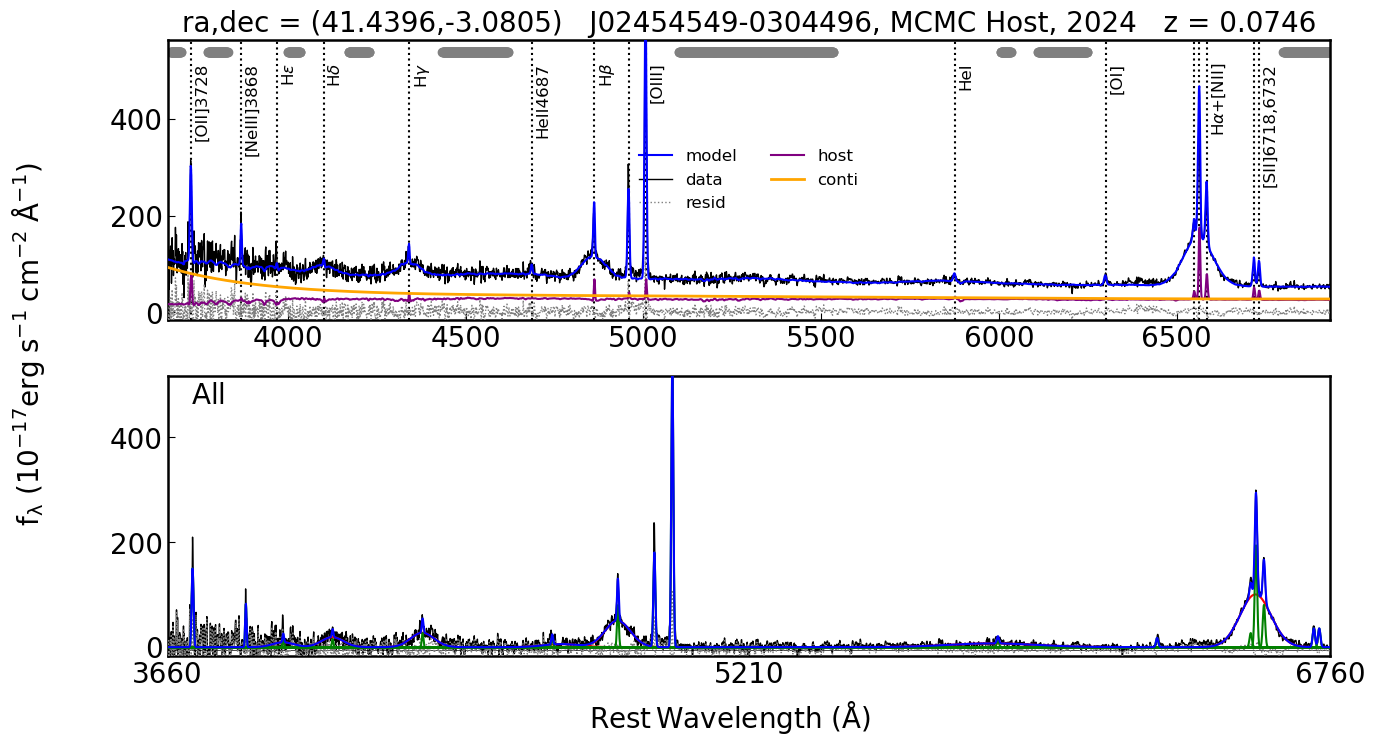

In [389]:
q_mcmc = QSOFit(lam, flux, err, z, ra=ra, dec=dec, path=path_ex)

start = timeit.default_timer()
# Do the fitting
q_mcmc.Fit(name='J02454549-0304496, MCMC Host, 2024', nsmooth=1, deredden=False, reject_badpix=False, wave_range=None, \
               wave_mask=None, decompose_host=True, host_prior=True, host_prior_scale=0.1, decomp_na_mask=True, npca_gal=5, host_type='PCA', npca_qso=10, \
               qso_type='CZBIN1', Fe_uv_op=True, poly=True, rej_abs_conti=False, rej_abs_line=True, MCMC=True, nsamp=400, linefit=True, \
               plot_fig=True, save_fig=False, save_result=True, plot_corner=False, kwargs_plot={'save_fig_path': '.'}, save_fits_name='MCMC_fits', verbose=False)

end = timeit.default_timer()

print(f'Fitting finished in {np.round(end - start, 1)}s')

## Model Components

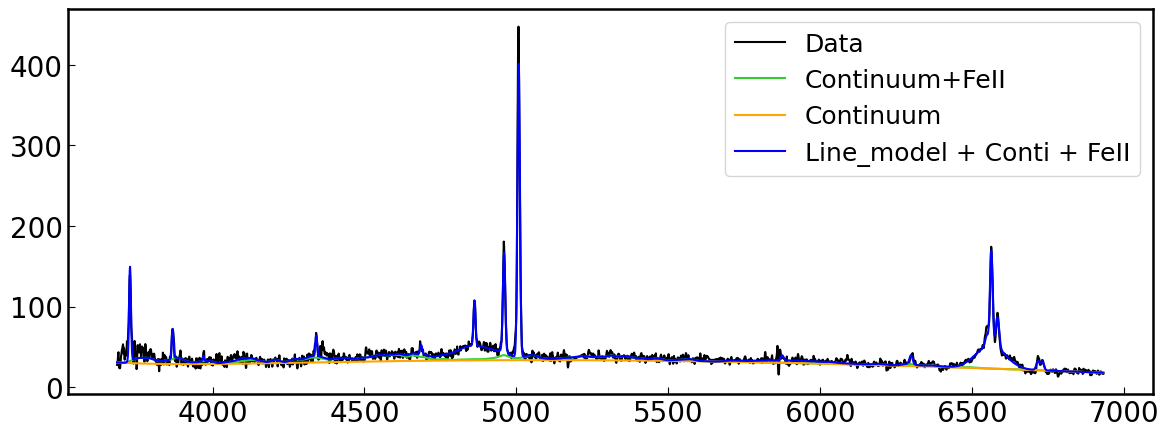

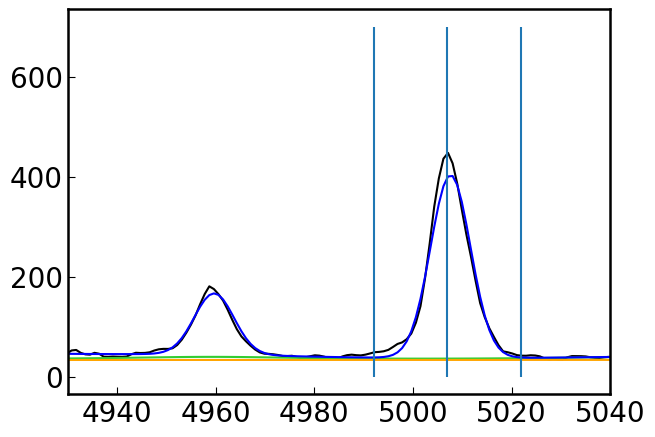

In [312]:
plt.figure(figsize=[14,5])
plt.plot(q_mcmc.wave, q_mcmc.flux, color='black', label='Data')
plt.plot(q_mcmc.wave, q_mcmc.f_conti_model, color='limegreen', label='Continuum+FeII')
plt.plot(q_mcmc.wave, q_mcmc.PL_poly_BC, color='orange', label='Continuum')
plt.plot(q_mcmc.wave, q_mcmc.f_line_model+q_mcmc.f_conti_model, 'blue', label='Line_model + Conti + FeII')
plt.legend()
plt.show()

plt.figure(figsize=[7,5])
plt.plot(q_mcmc.wave, q_mcmc.flux, color='black', label='Data')
plt.plot(q_mcmc.wave, q_mcmc.f_conti_model, color='limegreen', label='Continuum+FeII')
plt.plot(q_mcmc.wave, q_mcmc.PL_poly_BC, color='orange', label='Continuum')
plt.plot(q_mcmc.wave, q_mcmc.f_line_model+q_mcmc.f_conti_model, 'blue', label='Line_model + Conti + FeII')
plt.vlines(5007, 0, 700)
plt.vlines(5007-15, 0, 700) # 5004+-15 for 04 and 24, 5006/7+-17 for 22
plt.vlines(5007+15, 0, 700)
plt.xlim(4930, 5040)
#plt.legend()
plt.show()

### Integrate Narrow [OIII]

In [313]:
# Integrate around [O III]5007
min = np.where(q_mcmc.wave > 5007-15)[0][0]
max = np.where(q_mcmc.wave < 5007+15)[-1][-1]

integrated_OIII5007_04 = np.trapz(q_mcmc.flux[min:max+1], x=q_mcmc.wave[min:max+1], dx=1) - np.trapz(q_mcmc.f_conti_model[min:max+1], x=q_mcmc.wave[min:max+1], dx=1)
integrated_OIII5007_04

3981.2000088092227

In [309]:
3766/3978

0.9467068878833584

## Save Results

In [211]:
# Tabulate Line Parameters
line_name = ['Ha_br', 'Ha_na', 'NII6549', 'NII6585', 'SII6718', 'SII6732', 'OI6300', 'HeI5875_br', 'HeI5875_na', 'Hb_br', 'Hb_na', 'OIII4959c', 'OIII4959w', 'OIII5007c', 'OIII5007w', 'HeII4687_br', 'HeII4687_na', 'Hg_br', 'Hg_na', 'Hd_br', 'Hd_na', 'Hep_br', 'Hep_na', 'NeIII3868', 'OII3728']
line_type = ['broad', 'narrow', 'narrow', 'narrow', 'narrow', 'narrow', 'narrow', 'broad', 'narrow', 'broad', 'narrow', 'narrow', 'broad', 'narrow', 'broad', 'broad', 'narrow', 'broad', 'narrow', 'broad', 'narrow', 'broad', 'narrow', 'narrow', 'narrow']
# 2004 and 2022
#line_name = ['Ha_br', 'Ha_na', 'NII6549', 'NII6585', 'SII6718', 'SII6732', 'OI6300', 'HeI5875_br', 'HeI5875_na', 'Hb_br', 'Hb_na', 'OIII4959c', 'OIII4959w', 'OIII5007c', 'OIII5007w', 'HeII4687_br', 'HeII4687_na', 'Hg_br', 'Hg_na', 'Hd_br', 'Hd_na', 'Hep_br', 'Hep_na', 'NeIII3868', 'OII3728']
#line_type = ['broad', 'narrow', 'narrow', 'narrow', 'narrow', 'narrow', 'narrow', 'broad', 'narrow', 'broad', 'narrow', 'narrow', 'broad', 'narrow', 'broad', 'broad', 'narrow', 'broad', 'narrow', 'broad', 'narrow', 'broad', 'narrow', 'narrow', 'narrow']
fwhm_list = []
sigma_list = []
ew_list = []
peak_list = []
area_list = []
snr_list = []

for i in range(len(line_name)):
    fwhm, sigma, ew, peak, area, snr = q_mcmc.line_prop_from_name(line_name[i], line_type[i])
    fwhm_list.append(fwhm)
    sigma_list.append(sigma)
    ew_list.append(ew)
    peak_list.append(peak)
    area_list.append(area)
    snr_list.append(snr)


# Use pandas dataframe to display the parameters
my_dict = {'Line': line_name, 'Type': line_type, 'FWHM': fwhm_list, 'Sigma': sigma_list, 'EW': ew_list, 'Peak': peak_list, 'Area': area_list, 'SNR': snr_list}

# specifying the columns makes sure they are in the desired order
df = pd.DataFrame(my_dict, columns=['Line', 'Type', 'FWHM', 'Sigma', 'EW', 'Peak', 'Area', 'SNR'])
df = df.sort_values(by='SNR', ascending=False)

print('MY LINE PARAMETER DATAFRAME')
df
#df.to_csv('/Users/joel/Library/CloudStorage/OneDrive-UniversityofSouthampton/Post Grad/ZTF18abuamgo_CLAGN_Project/MCMC_Fits/2024_no_prior_host_line_parameters.csv')

MY LINE PARAMETER DATAFRAME


,Line,Type,FWHM,Sigma,EW,Peak,Area,SNR
13,OIII5007c,narrow,580.638539,243.114347,1.107888e+02,5007.485495,4.015336e+03,5.833935e+01
1,Ha_na,narrow,468.890435,196.248008,5.538180e+01,6564.201623,1.373650e+03,2.465804e+01
11,OIII4959c,narrow,580.638342,243.114265,3.662975e+01,4959.550605,1.325633e+03,2.023961e+01
24,OII3728,narrow,875.895489,365.636452,3.358846e+01,3726.764294,1.084204e+03,1.361941e+01
0,Ha_br,broad,4854.642267,2034.016152,1.550752e+02,6563.034744,3.844644e+03,1.016948e+01
10,Hb_na,narrow,468.890049,196.247846,1.369370e+01,4862.373767,4.929410e+02,9.098393e+00
3,NII6585,narrow,444.889253,183.518600,1.956139e+01,6584.355613,4.794820e+02,8.980503e+00
23,NeIII3868,narrow,444.880670,183.515060,9.505764e+00,3868.142447,2.942080e+02,8.362793e+00
18,Hg_na,narrow,468.890223,196.247919,6.036244e+00,4341.408211,2.006068e+02,5.794717e+00
9,Hb_br,broad,8835.560401,3702.388530,7.798394e+01,4860.947698,2.805568e+03,4.039389e+00


In [156]:
# Line fitting results
line_parameters = np.column_stack((q_mcmc.line_result_name, q_mcmc.line_result))
print(line_parameters)
#line_parameters

[['1_complex_name' 'All']
 ['1_line_status' '1']
 ['1_line_min_chi2' '2860.060759022931']
 ['1_line_bic' '-149.82466312339642']
 ['1_line_red_chi2' '0.881918211231246']
 ['1_niter' '929']
 ['1_ndof' '3243']
 ['Ha_br_1_scale' '101.49627804878492']
 ['Ha_br_1_scale_err' '3.301840811550477']
 ['Ha_br_1_centerwave' '8.788991513901646']
 ['Ha_br_1_centerwave_err' '1.7063007449635847e-05']
 ['Ha_br_1_sigma' '0.00611461657788303']
 ['Ha_br_1_sigma_err' '0.00013153053896994933']
 ['Ha_na_1_scale' '190.93795933233793']
 ['Ha_na_1_scale_err' '7.681432236519797']
 ['Ha_na_1_centerwave' '8.78912392503428']
 ['Ha_na_1_centerwave_err' '1.1180221241247068e-05']
 ['Ha_na_1_sigma' '0.0004913800214292564']
 ['Ha_na_1_sigma_err' '1.9655347031958794e-05']
 ['NII6549_1_scale' '26.71615317861864']
 ['NII6549_1_scale_err' '1.0716120798445914']
 ['NII6549_1_centerwave' '8.786995733573992']
 ['NII6549_1_centerwave_err' '1.3343901375861833e-05']
 ['NII6549_1_sigma' '0.0004652797678544328']
 ['NII6549_1_sigma_er

In [390]:
# Continuum fitting results
conti_parameters = np.column_stack((q_mcmc.conti_result_name, q_mcmc.conti_result))
#print(conti_parameters)

# Extracting the column names (left side of the tuple)
column_names = conti_parameters[:, 0]

# Extracting the corresponding values (right side of the tuple)
row_data = conti_parameters[:, 1]

# Creating the DataFrame
conti_df = pd.DataFrame([row_data], columns=column_names)
conti_df
#conti_df.to_csv('/Users/joel/Library/CloudStorage/OneDrive-UniversityofSouthampton/Post Grad/ZTF18abuamgo_CLAGN_Project/MCMC_Fits/2024_no_prior_host_conti_parameters.csv')

,ra,dec,plateid,MJD,fiberid,redshift,SN_ratio_conti,Fe_uv_norm,Fe_uv_norm_err,Fe_uv_FWHM,...,qso_par_0,qso_par_1,qso_par_2,qso_par_3,qso_par_4,qso_par_5,qso_par_6,qso_par_7,qso_par_8,qso_par_9
0,41.43958,-3.08047,0,0,0,0.07455,13.854116412757259,0.0,0.0,3000.0,...,3068.188944924834,76.89538483727075,93.39758935957873,107.26034699778313,112.08341285994688,-38.33944105062549,9.583094750902497,-15.805300612515667,-35.382999391891374,-36.413408311301886


# Import Spectra Model

In [335]:
# Import residuals and obtain residual std dev across spectrum in 100A bins
model_file = np.load('/Users/joel/Library/CloudStorage/OneDrive-UniversityofSouthampton/Post Grad/ZTF18abuamgo_CLAGN_Project/ZTF18abuamgo_Analysis/PyQSOFit Spectra Models/2022_ngauss1_br_balmer_untied.npz')
model = model_file['model']
residuals = model_file['resid']

#model_file = np.load('/Users/joel/Library/CloudStorage/OneDrive-UniversityofSouthampton/Post Grad/ZTF18abuamgo_CLAGN_Project/ZTF18abuamgo_Analysis/PyQSOFit Spectra Models/pyqsofit_new_model.npz')
#model = model_file['model']
#residuals = model_file['resid']

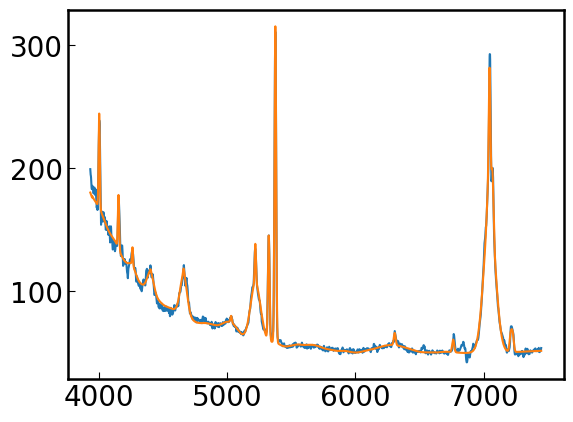

In [336]:
plt.plot(lam, flux)
plt.plot(lam, model)
#plt.xlim(5100, 5500)
plt.show()

# Prepare Residual Values

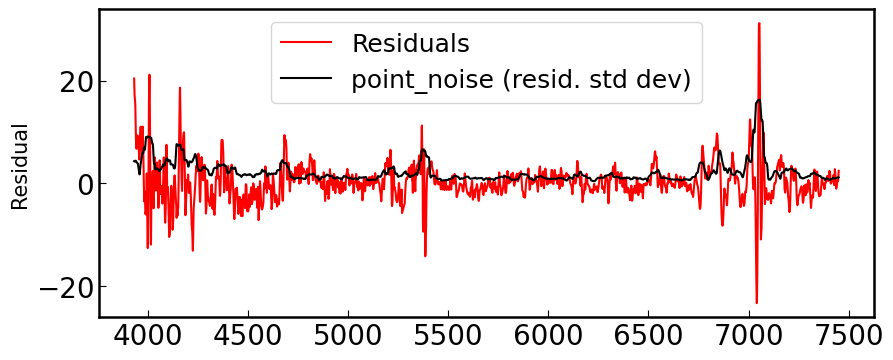

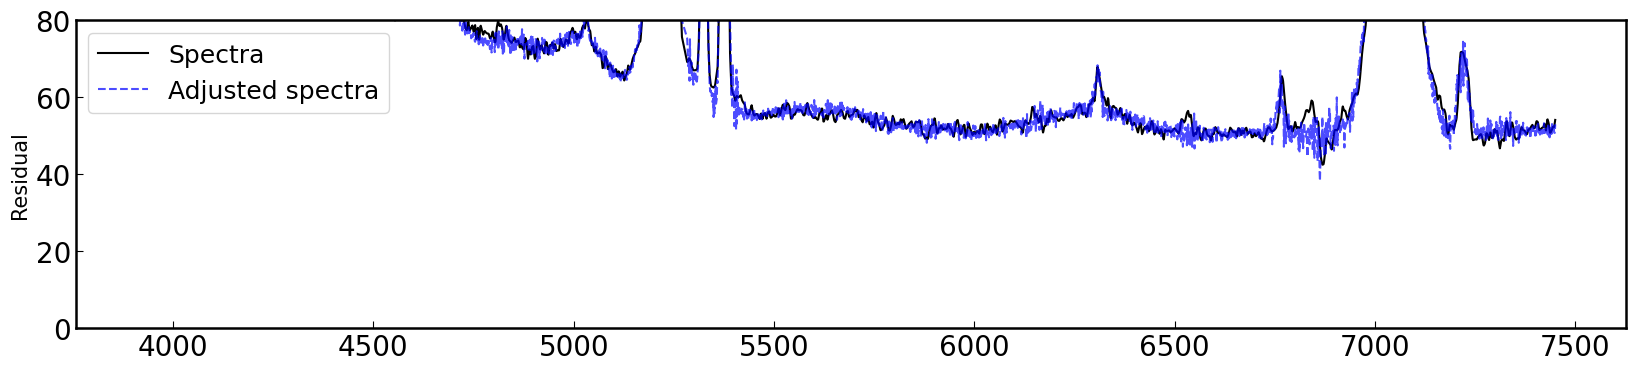

In [340]:
# Alternate noise method sampling surrounding pixels at every point rather than in continuum bins to account for increased uncertainty in emission lines
# 2004 ylim -30,30, noise_window=15
# 2022 ylim -20,20, noise_window=20
# 2024 ylim -50,50, noise_window=15
point_noise = np.zeros(len(residuals)) # array to hold noise value at each point
for i in range(len(point_noise)):
    noise_window = 20 # angstrom +- from current point residuals are measured from
    nearby_index = np.where((lam > lam[i] - noise_window) & (lam < lam[i] + noise_window))
    #print(lam[nearby_index[0][0]], lam[i], lam[nearby_index[0][-1]])
    
    # Set point noise to be std dev of residuals within noise_window (Angstrom)
    point_noise[i] = np.std(residuals[nearby_index[0][0]:nearby_index[0][-1]+1])


plt.figure(figsize=(10,4))
plt.plot(lam,residuals, color='red', label='Residuals')
plt.plot(lam,point_noise, color='black', label='point_noise (resid. std dev)')
plt.ylabel('Residual')
plt.legend()
#plt.ylim(-30,30)
plt.show()

adjusted_flux = np.zeros_like(flux)
for f in range(len(adjusted_flux)):
    adjusted_flux[f] = r.gauss(mu = model[f], sigma = point_noise[f])
plt.figure(figsize=(20,4))
plt.plot(lam,flux, color='black', label='Spectra')
plt.plot(lam,adjusted_flux, color='blue', linestyle='--', label='Adjusted spectra', alpha=0.7)
plt.ylabel('Residual')
plt.legend()
plt.ylim(0,80)
plt.show()

# Perform Multiple Fits

In [341]:
# DataFrame structure
# 2024
#line_name = ['Ha_br', 'Ha_na', 'NII6549', 'NII6585', 'SII6718', 'SII6732', 'OI6300', 'HeI5875_br', 'HeI5875_na', 'Hb_br', 'Hb_na', 'OIII4959c', 'OIII4959w', 'OIII5007c', 'OIII5007w', 'HeII4687_br', 'HeII4687_na', 'Hg_br', 'Hg_na', 'Hd_br', 'Hd_na', 'Hep_br', 'Hep_na', 'NeIII3868', 'OII3728']
#line_type = ['broad', 'narrow', 'narrow', 'narrow', 'narrow', 'narrow', 'narrow', 'broad', 'narrow', 'broad', 'narrow', 'narrow', 'broad', 'narrow', 'broad', 'broad', 'narrow', 'broad', 'narrow', 'broad', 'narrow', 'broad', 'narrow', 'narrow', 'narrow']
# 2004, 2022
line_name = ['Ha_br', 'Ha_na', 'NII6549', 'NII6585', 'SII6718', 'SII6732', 'OI6300', 'HeI5875_br', 'HeI5875_na', 'Hb_br', 'Hb_na', 'OIII4959c', 'OIII5007c', 'HeII4687_br', 'HeII4687_na', 'Hg_br', 'Hg_na', 'Hd_br', 'Hd_na', 'Hep_br', 'Hep_na', 'NeIII3868', 'OII3728']
line_type = ['broad', 'narrow', 'narrow', 'narrow', 'narrow', 'narrow', 'narrow', 'broad', 'narrow', 'broad', 'narrow', 'narrow', 'narrow', 'broad', 'narrow', 'broad', 'narrow', 'broad', 'narrow', 'broad', 'narrow', 'narrow', 'narrow']

adjusted_line_priors = copy.deepcopy(line_priors) # create copy of line_priors avoiding shallow copy!
# Loop to fit spectra
for i in range(200):
    
    # Resample spectra to simulate different noise based on residuals across spectra
    bin = 0 # wavelength bin
    adjusted_flux = np.zeros_like(flux)
    for f in range(len(adjusted_flux)):
        adjusted_flux[f] = r.gauss(mu = model[f], sigma = point_noise[f])
    
    #'''
    # Alter initial line priors
    #adjusted_line_priors = line_priors # create copy of line_priors to be altered
    '''
    Generate random line_prior from normal distribution within limits of prior using truncnorm
    truncnorm.rvs(a, b, loc=mean, scale=std)
    Where:  a, b = (lower - mean) / std, (upper - mean) / std
    '''
    for l in range(len(line_priors)): # loop over each line
        # Change initial scale
        adjusted_line_priors[l][6] = truncnorm.rvs((line_priors[l][7] - line_priors[l][6]) / (0.1*line_priors[l][6]), (line_priors[l][8] - line_priors[l][6]) / (0.1*line_priors[l][6]), loc=line_priors[l][6], scale=0.1*line_priors[l][6])
        # Change initial scale
        adjusted_line_priors[l][9] = truncnorm.rvs((line_priors[l][10] - line_priors[l][9]) / (0.1*line_priors[l][9]), (line_priors[l][11] - line_priors[l][9]) / (0.1*line_priors[l][9]), loc=line_priors[l][9], scale=0.1*line_priors[l][9])

        '''
        # Loop to regenerate value until within the min-max range of prior
        within_range = False
        while within_range == False:
            # Change initial scale
            adjusted_line_priors[l][6] = r.gauss(mu = line_priors[l][6], sigma = 0.1*line_priors[l][6]) # gaussian distribution centered on original val, sigma of 10%
            # Change initial sigma
            adjusted_line_priors[l][9] = r.gauss(mu = line_priors[l][9], sigma = 0.1*line_priors[l][9])
            # check both scale and sigma are within limits outlined in prior
            if (adjusted_line_priors[l][7] < adjusted_line_priors[l][6] < adjusted_line_priors[l][8] and
                adjusted_line_priors[l][10] < adjusted_line_priors[l][9] < adjusted_line_priors[l][11]):
                within_range = True
        '''
    # Save line info
    hdu1 = fits.BinTableHDU(data=adjusted_line_priors, header=hdr1, name='line_priors')
    
    hdu_list = fits.HDUList([primary_hdu, hdu1, hdu2, hdu3, hdu4])
    hdu_list.writeto(os.path.join(path_ex, 'qsopar.fits'), overwrite=True)
    #'''
    #print(adjusted_line_priors)
    
    # Run fitting
    q_mcmc = QSOFit(lam, adjusted_flux, err, z, ra=ra, dec=dec, path=path_ex)
    
    start = timeit.default_timer()

    q_mcmc.Fit(name=f'Fit_{i}, 2024', nsmooth=1, deredden=False, reject_badpix=False, wave_range=None, \
               wave_mask=None, decompose_host=False, host_prior=False, host_prior_scale=0.1, decomp_na_mask=True, Fe_uv_op=True, poly=True, rej_abs_conti=False, rej_abs_line=True, MCMC=False, nsamp=400, linefit=True, \
               plot_fig=False, save_fig=False, save_result=False, plot_corner=False, kwargs_plot={'save_fig_path': '.'}, save_fits_name=None, verbose=False)
    
    end = timeit.default_timer()
                    
    print(f'Fit_{i} finished in {np.round(end - start, 1)}s')
    # Create line parameter dataframe
    fwhm_list = [] # Create empty parameter lists
    sigma_list = []
    ew_list = []
    peak_list = []
    area_list = []
    snr_list = []
    l5100_list = []
    
    for j in range(len(line_name)): # for each fit line
        try:
            fwhm, sigma, ew, peak, area, snr = q_mcmc.line_prop_from_name(line_name[j], line_type[j])
            fwhm_list.append(fwhm)
            sigma_list.append(sigma)
            ew_list.append(ew)
            peak_list.append(peak)
            area_list.append(area)
            snr_list.append(snr)
        except:
            print(f'Fit_{i} failed to obtain line_prop_from_name')
            fwhm_list.append(-1)
            sigma_list.append(-1)
            ew_list.append(-1)
            peak_list.append(-1)
            area_list.append(-1)
            snr_list.append(-1)
        if j == 0:
            l5100_list.append(q_mcmc.conti_result[q_mcmc.conti_result_name == 'L5100'][0])
        else:
            l5100_list.append(np.nan)
    
    # Create DataFrame using a dictionary (column-wise)
    df = pd.DataFrame({
        "fwhm": fwhm_list,
        "sigma": sigma_list,
        "ew": ew_list,
        "peak": peak_list,
        "area": area_list,
        "snr": snr_list,
        "logl5100": l5100_list
    }, index=line_name)  # Assign row labels
    
    # Combine this fit with overall dataframe and save line fitting parameters
    if i == 0:
        original_df = df
        original_df = original_df.applymap(lambda x: [x])
        # create initial list to hold line fitting parameters
        #line_parameters = np.column_stack((q_mcmc.line_result_name[7:82], q_mcmc.line_result[7:82].astype(float))) # 7:82 keeps only the line fit params
        line_parameters = q_mcmc.line_result[7:82].astype(float) # 7:82 keeps only the line fit params
    else:
        df_wrapped = df.applymap(lambda x: [x])
        original_df = original_df + df_wrapped
        # next line fitting parameters to list created on first fit
        line_parameters = line_parameters = np.column_stack((line_parameters, q_mcmc.line_result[7:82].astype(float)))
    
#original_df.to_csv('/Users/joel/Library/CloudStorage/OneDrive-UniversityofSouthampton/Post Grad/ZTF18abuamgo_CLAGN_Project/ZTF18abuamgo_Analysis/Multi-fit Line Parameters/2024_ngauss1_fits200.csv')

Fit_0 finished in 1.4s
Fit_1 finished in 1.9s
Fit_2 finished in 1.3s
Fit_3 finished in 1.3s
Fit_4 finished in 1.4s
Fit_5 finished in 1.4s
Fit_6 finished in 1.2s
Fit_7 finished in 1.9s
Fit_8 finished in 1.3s
Fit_9 finished in 1.2s
Fit_10 finished in 1.7s
Fit_11 finished in 1.7s
Fit_12 finished in 1.2s
Fit_13 finished in 1.9s
Fit_14 finished in 1.2s
Fit_15 finished in 1.4s
Fit_16 finished in 1.4s
Fit_17 finished in 1.2s
Fit_18 finished in 1.3s
Fit_19 finished in 1.5s
Fit_20 finished in 1.3s
Fit_21 finished in 1.3s
Fit_22 finished in 1.3s
Fit_23 finished in 1.3s
Fit_24 finished in 1.5s
Fit_25 finished in 1.2s
Fit_26 finished in 1.5s
Fit_27 finished in 1.3s
Fit_28 finished in 1.2s
Fit_29 finished in 2.0s
Fit_30 finished in 1.4s
Fit_31 finished in 1.3s
Fit_32 finished in 1.3s
Fit_33 finished in 2.0s
Fit_34 finished in 1.5s
Fit_35 finished in 1.2s
Fit_36 finished in 1.8s
Fit_37 finished in 2.7s
Fit_38 finished in 2.4s
Fit_39 finished in 1.3s
Fit_40 finished in 1.3s
Fit_41 finished in 1.4s
Fi

In [345]:
original_df
#original_df.to_csv('/Users/joel/Library/CloudStorage/OneDrive-UniversityofSouthampton/Post Grad/ZTF18abuamgo_CLAGN_Project/ZTF18abuamgo_Analysis/Multi-fit Line Parameters/2022_ngauss1_br_hbha_untied_fits200.csv')

,fwhm,sigma,ew,peak,area,snr,logl5100
Ha_br,"[4443.221161351922, 4449.732157464073, 4474.95...","[1861.388707177498, 1864.1166339426081, 1874.9...","[238.64544927566195, 237.43497888843643, 238.2...","[6558.030859579575, 6557.755296242687, 6558.90...","[12906.839863486748, 12898.785141854147, 12926...","[55.34611425954082, 58.10887275827453, 55.8348...","[43.594649468749694, 43.59752598121006, 43.596..."
Ha_na,"[624.9100301312372, 715.5938400516565, 621.817...","[261.671051559796, 298.13648036767745, 258.466...","[31.42176450336199, 35.90194465295327, 33.3164...","[6558.235045169815, 6557.531149683417, 6557.42...","[1699.2313549743055, 1950.2000414495624, 1807....","[30.9097246047781, 28.90713056444545, 31.80303...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
NII6549,"[818.5808410992835, 830.0151651078037, 821.251...","[341.53543922513916, 346.30618450446514, 342.6...","[5.774766944443365, 5.309297773298607, 6.00032...","[6542.702372236454, 6542.781666905922, 6542.71...","[312.03611633341774, 288.14750121007717, 325.3...","[4.5952715402541555, 3.8292687722384895, 4.517...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
NII6585,"[818.5810675121642, 830.0153946833423, 821.252...","[341.53553370820777, 346.3062802588898, 342.64...","[17.38374949902173, 15.97964562905624, 18.0662...","[6578.095215448121, 6578.174939063251, 6578.10...","[941.1722406676897, 869.1187178695227, 981.227...","[12.104358961913906, 10.663382697737589, 12.06...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
SII6718,"[818.5809053770336, 830.0152302833882, 821.251...","[341.53546611043635, 346.3062117380229, 342.64...","[5.512560879818408, 5.406478605386553, 5.47911...","[6710.959025342152, 6711.0403592081075, 6710.9...","[300.89103369448213, 296.71384566637164, 299.7...","[3.041523863943143, 2.7792721192968086, 3.0234...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
SII6732,"[818.5809193491508, 830.0152444507354, 821.251...","[341.5354719646457, 346.306217581782, 342.6499...","[5.519126289193975, 5.412300294682677, 5.48621...","[6725.323331585982, 6725.404839540998, 6725.33...","[301.53506846472817, 297.34893947782916, 300.3...","[2.838667735831354, 2.6387012696192476, 2.7071...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
OI6300,"[818.5807436591414, 830.0150663065676, 821.251...","[341.5353986469818, 346.30614326635174, 342.64...","[3.3512425055178308, 3.50573707565046, 3.70708...","[6293.423659561626, 6293.49993308295, 6293.431...","[179.0258965553856, 187.96810379790654, 198.90...","[2.2308919857491443, 2.235111916548328, 2.4532...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
HeI5875_br,"[13298.92329576983, 12889.823887020388, 13083....","[5574.321900529254, 5402.615106940657, 5483.94...","[41.20248844717982, 38.976575023187486, 38.354...","[5846.315617216314, 5846.344847239163, 5846.31...","[2186.6752304476827, 2077.346866186814, 2045.4...","[7.3754451454885555, 6.723720751444897, 7.1564...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
HeI5875_na,"[818.5811495820566, 830.0154778996026, 821.252...","[341.5355679385869, 346.30631498767303, 342.65...","[3.3019110314379763, 3.1788432646606535, 3.440...","[5869.210377791419, 5869.281510034713, 5869.21...","[175.0730122392033, 169.2583845440248, 183.312...","[3.003384970423333, 2.9784281373611043, 3.3360...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
Hb_br,"[5240.812279264975, 5124.337208892694, 5203.06...","[2195.8400311982055, 2147.0309505127857, 2179....","[77.02080088385026, 75.22181840076101, 76.8886...","[4858.366007427286, 4858.162711549526, 4857.89...","[4667.718728578967, 4588.322211864176, 4680.42...","[17.068950422621345, 15.626003740395394, 16.34...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."


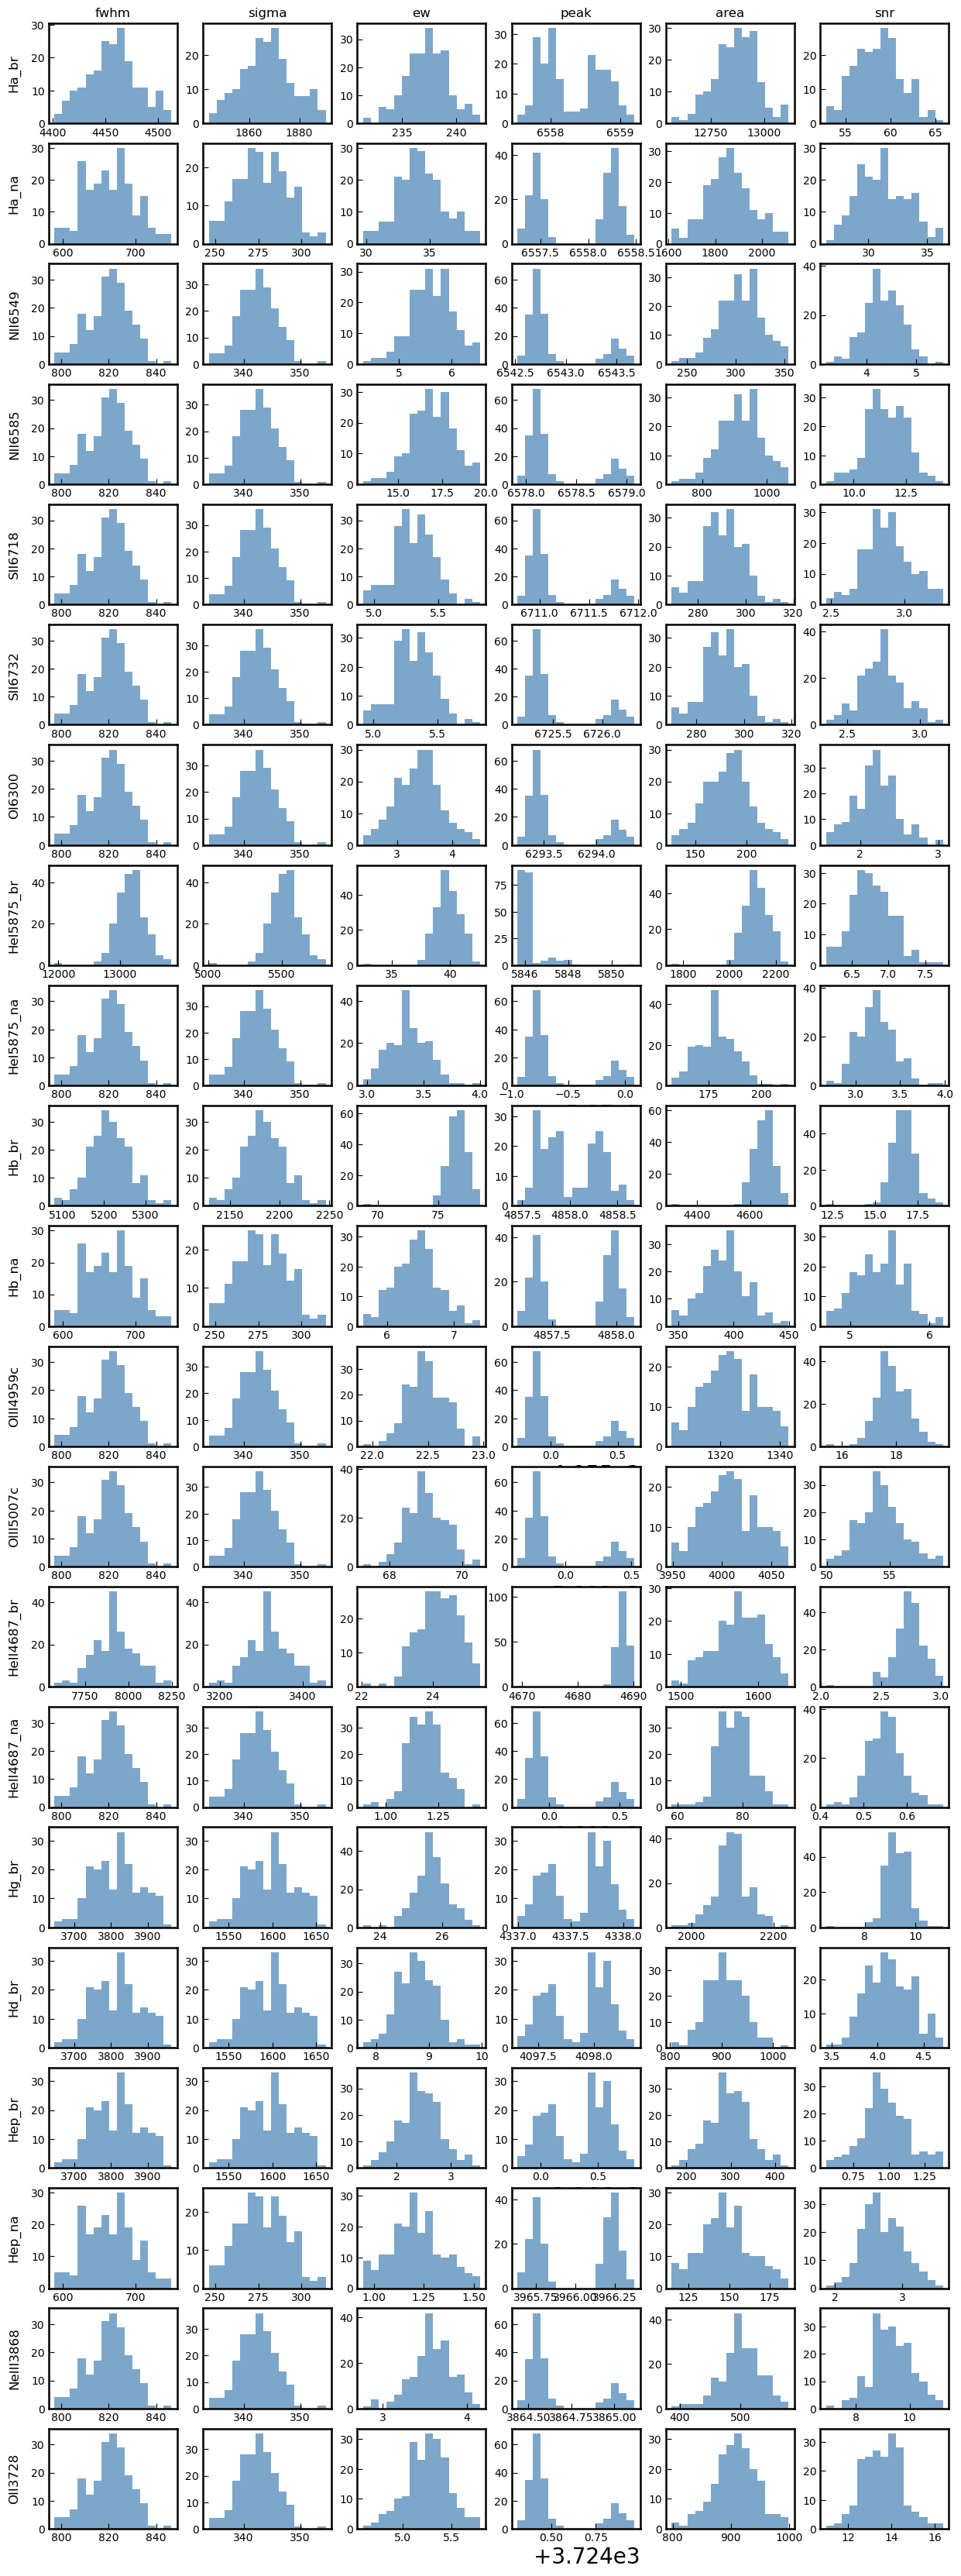

In [343]:
def plot_dataframe_histograms(df, selected_rows=None, bins=15):
    """
    Plots histograms for each cell in the DataFrame, arranged in a grid matching the DataFrame structure.
    
    Parameters:
    - df: Pandas DataFrame containing lists of float values in each cell.
    - selected_rows: List of row indexes to include (default: all rows).
    - bins: Number of bins for the histograms.
    """
    
    df = df.iloc[:, :-1]  # Keep all columns except the last one
    
    # Filter selected rows if specified
    if selected_rows is not None:
        df = df.loc[selected_rows]

    num_rows, num_cols = df.shape

    # Create figure and axes
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(2.5 * num_cols, 2 * num_rows))
    # Ensure axes is always 2D (even if there's only one row/col)
    if num_rows == 1:
        axes = np.expand_dims(axes, axis=0)
    if num_cols == 1:
        axes = np.expand_dims(axes, axis=1)

    # Iterate over rows and columns to plot histograms
    for i, row_label in enumerate(df.index):
        for j, col_label in enumerate(df.columns):
            ax = axes[i, j]
            ax.hist(df.loc[row_label, col_label], bins=bins, color='steelblue', alpha=0.7)
            ax.tick_params(axis='both', which='both', labelsize=10)
            #ax.vlines(df.loc[row_label, col_label][49], 0, 10, color='black')
            #ax.set_xticks([])
            #ax.set_yticks([])
            
            # Column labels (top row)
            if i == 0:
                ax.set_title(col_label, fontsize=12, pad=6)

            # Row labels (left-most column)
            if j == 0:
                ax.set_ylabel(row_label, fontsize=12, rotation=90, labelpad=10)
    
    #plt.subplots_adjust(wspace=0, hspace=0)
    
    # Save figure
    custom_path = "/Users/joel/Library/CloudStorage/OneDrive-UniversityofSouthampton/Post Grad/ZTF18abuamgo_CLAGN_Project/MyPlots/"
    custom_filename = "2024_ngauss1_fits200_line_parameters.png"
    save_path = custom_path + custom_filename
    #plt.savefig(save_path)
    plt.show()

# OIII4959w, OIII5007w only included in 2024 fit.
#plot_dataframe_histograms(df_24, selected_rows=['Ha_br', 'Ha_na', 'NII6549', 'NII6585', 'SII6718', 'SII6732', 'OI6300', 'HeI5875_br', 'HeI5875_na', 'Hb_br', 'Hb_na', 'OIII4959c', 'OIII4959w', 'OIII5007c', 'OIII5007w', 'HeII4687_br', 'HeII4687_na', 'Hg_br', 'Hd_br', 'Hep_br', 'Hep_na', 'NeIII3868', 'OII3728'])
plot_dataframe_histograms(original_df, selected_rows=['Ha_br', 'Ha_na', 'NII6549', 'NII6585', 'SII6718', 'SII6732', 'OI6300', 'HeI5875_br', 'HeI5875_na', 'Hb_br', 'Hb_na', 'OIII4959c', 'OIII5007c', 'HeII4687_br', 'HeII4687_na', 'Hg_br', 'Hd_br', 'Hep_br', 'Hep_na', 'NeIII3868', 'OII3728'])

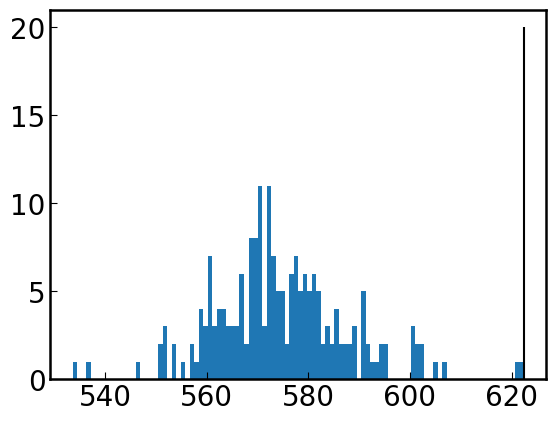

59

In [97]:
#plt.hist(original_df.at['Ha_na','peak'], bins=30)
#plt.show()
extreme_index = original_df.at['OIII4959c','fwhm'].index(max(original_df.at['OIII4959c','fwhm']))

plt.hist(original_df.at['OIII4959c','fwhm'], bins=100)
plt.vlines(original_df.at['OIII4959c','fwhm'][extreme_index], 0, 20, color='black')
#plt.vlines(np.mean(original_df.at['OIII4959c','fwhm']), 0, 20, color='black') # mean line
plt.show()
extreme_index


In [413]:
print(q_mcmc.line_result_name[7:82])
line_parameters

['Ha_br_1_scale' 'Ha_br_1_centerwave' 'Ha_br_1_sigma' 'Ha_na_1_scale'
 'Ha_na_1_centerwave' 'Ha_na_1_sigma' 'NII6549_1_scale'
 'NII6549_1_centerwave' 'NII6549_1_sigma' 'NII6585_1_scale'
 'NII6585_1_centerwave' 'NII6585_1_sigma' 'SII6718_1_scale'
 'SII6718_1_centerwave' 'SII6718_1_sigma' 'SII6732_1_scale'
 'SII6732_1_centerwave' 'SII6732_1_sigma' 'OI6300_1_scale'
 'OI6300_1_centerwave' 'OI6300_1_sigma' 'HeI5875_br_1_scale'
 'HeI5875_br_1_centerwave' 'HeI5875_br_1_sigma' 'HeI5875_na_1_scale'
 'HeI5875_na_1_centerwave' 'HeI5875_na_1_sigma' 'Hb_br_1_scale'
 'Hb_br_1_centerwave' 'Hb_br_1_sigma' 'Hb_na_1_scale' 'Hb_na_1_centerwave'
 'Hb_na_1_sigma' 'OIII4959c_1_scale' 'OIII4959c_1_centerwave'
 'OIII4959c_1_sigma' 'OIII5007c_1_scale' 'OIII5007c_1_centerwave'
 'OIII5007c_1_sigma' 'HeII4687_br_1_scale' 'HeII4687_br_1_centerwave'
 'HeII4687_br_1_sigma' 'HeII4687_na_1_scale' 'HeII4687_na_1_centerwave'
 'HeII4687_na_1_sigma' 'Hg_br_1_scale' 'Hg_br_1_centerwave'
 'Hg_br_1_sigma' 'Hg_na_1_scale' 'Hg

array([[3.13435244e+01, 3.12921766e+01, 3.17530507e+01, ...,
        1.38068985e+02, 1.21379516e+02, 1.09688721e+02],
       [8.78909008e+00, 8.78911341e+00, 8.78937322e+00, ...,
        8.78944874e+00, 8.78944874e+00, 8.78944874e+00],
       [7.68667640e-03, 7.46233959e-03, 7.13446156e-03, ...,
        4.00000019e-03, 4.00000019e-03, 4.00000019e-03],
       ...,
       [6.56239429e+03, 6.56265688e+03, 6.56398709e+03, ...,
        6.56474109e+03, 6.56474109e+03, 6.56474109e+03],
       [8.77565125e+03, 7.87760395e+03, 8.79796039e+03, ...,
        1.31892864e+04, 1.18312851e+04, 1.11816273e+04],
       [1.11632486e+01, 1.06955498e+01, 1.11154779e+01, ...,
        3.70739505e+01, 3.36272335e+01, 2.83701582e+01]])

In [415]:
parameters = np.column_stack((q_mcmc.line_result_name, q_mcmc.line_result))
print(parameters)

[['1_complex_name' 'All']
 ['1_line_status' '1']
 ['1_line_min_chi2' '3874.9633935271577']
 ['1_line_bic' '956.0443501558924']
 ['1_line_red_chi2' '1.2788658064446066']
 ['1_niter' '36']
 ['1_ndof' '3030']
 ['Ha_br_1_scale' '109.68872088401582']
 ['Ha_br_1_centerwave' '8.789448738098145']
 ['Ha_br_1_sigma' '0.004000000189989805']
 ['Ha_na_1_scale' '63.28851331893759']
 ['Ha_na_1_centerwave' '8.789448738098145']
 ['Ha_na_1_sigma' '0.0005000000237487257']
 ['NII6549_1_scale' '10.274872619397968']
 ['NII6549_1_centerwave' '8.78719711303711']
 ['NII6549_1_sigma' '0.0012434148229658604']
 ['NII6585_1_scale' '30.824617858193903']
 ['NII6585_1_centerwave' '8.79259204864502']
 ['NII6585_1_sigma' '0.0012434148229658604']
 ['SII6718_1_scale' '10.877437839340587']
 ['SII6718_1_centerwave' '8.812588691711426']
 ['SII6718_1_sigma' '0.0012434148229658604']
 ['SII6732_1_scale' '10.877437839340587']
 ['SII6732_1_centerwave' '8.814726829528809']
 ['SII6732_1_sigma' '0.0012434148229658604']
 ['OI6300_1_

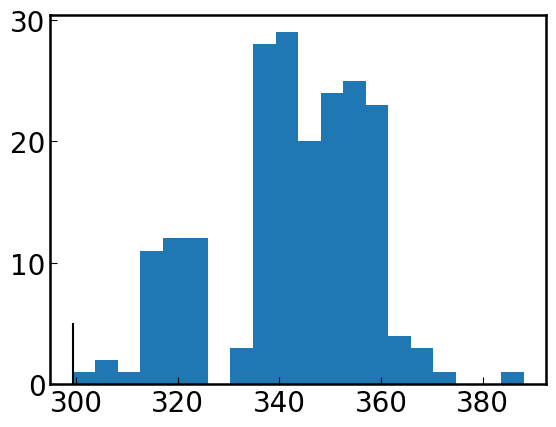

142

In [118]:
#plt.hist(original_df.at['Ha_na','peak'], bins=30)
#plt.show()
extreme_index = original_df.at['NII6549','fwhm'].index(min(original_df.at['NII6549','fwhm']))

plt.hist(original_df.at['NII6549','fwhm'], bins=20)
plt.vlines(original_df.at['NII6549','fwhm'][extreme_index], 0, 5, color='black')
plt.show()
extreme_index

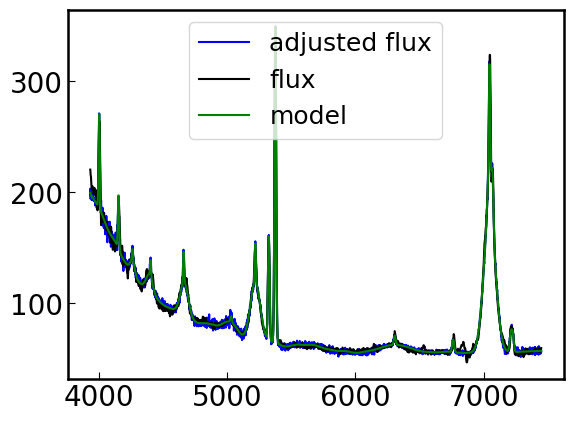

In [20]:
plt.plot(lam, adjusted_flux, color='blue', label='adjusted flux')
plt.plot(lam, flux, color='black', label='flux')
plt.plot(lam, model, color='green', label='model')
plt.legend()
plt.show()

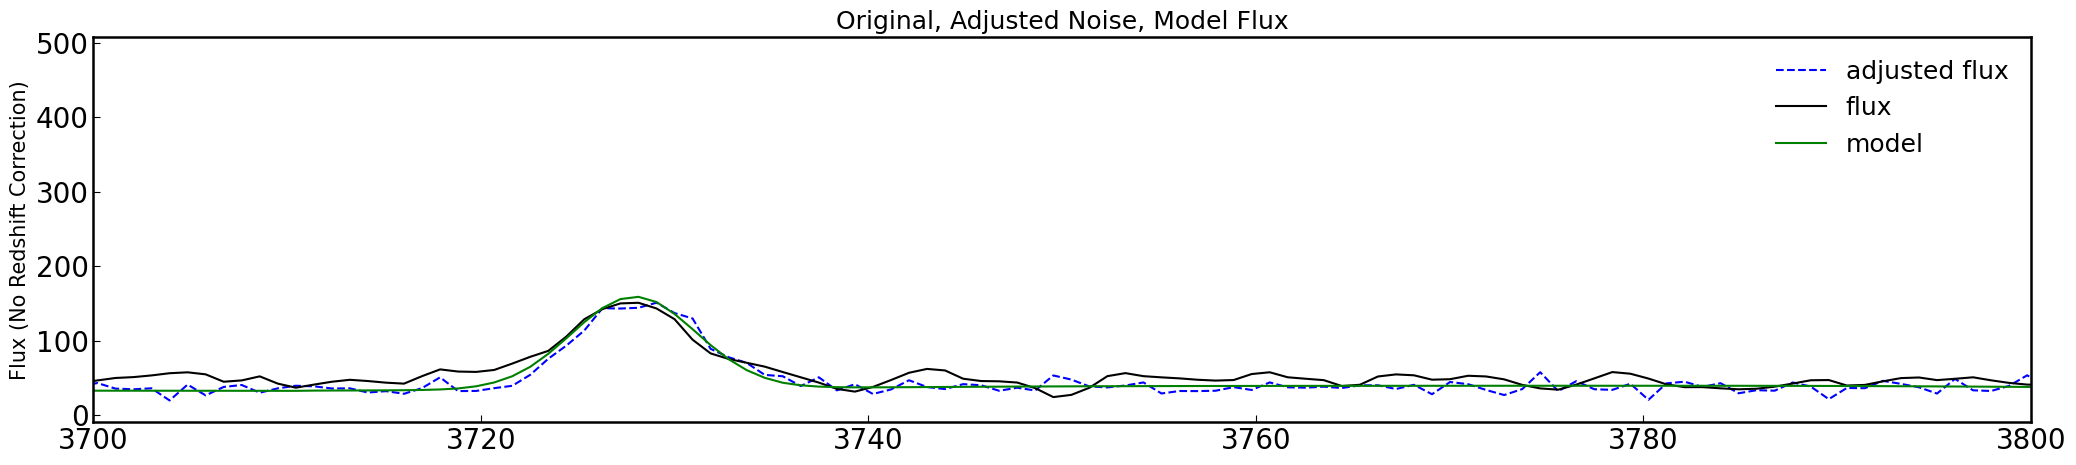

In [384]:
rest_lam = restFrameWavelength(lam, 0.074550)

plt.figure(figsize=(25,5))
plt.plot(rest_lam, adjusted_flux, color='blue', linestyle='--', label='adjusted flux')
plt.plot(rest_lam, flux, color = 'black', label='flux')
plt.plot(rest_lam, model, color='green', label='model')
#plt.plot(rest_lam, OIII_outlier_model, color='red', label='The great oxygen gap')
#plt.plot(pyqsofit_wave_prereduced, pyqsofit_flux_prereduced, color='black', label='Prereduced PyQSOFit data')
plt.legend(frameon=False)
#plt.text(5100, 0.1, 'Rest Wavelength')
plt.ylabel('Flux (No Redshift Correction)')
plt.xlim(3700, 3800)
#plt.ylim(20, 200)
plt.title('Original, Adjusted Noise, Model Flux')
plt.show()

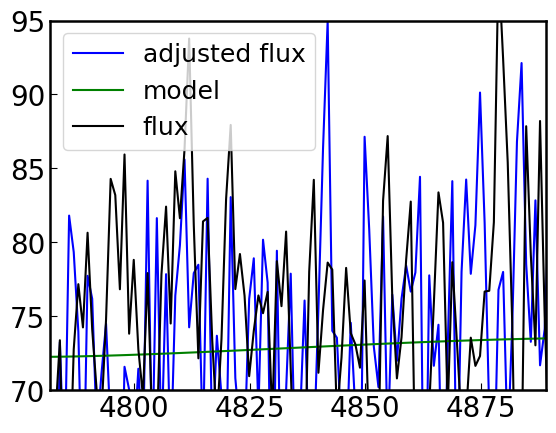

In [214]:
plt.plot(lam, adjusted_flux, color='blue', label='adjusted flux')
plt.plot(lam, model, color='green', label='model')
plt.plot(lam, flux, color = 'black', label='flux')
plt.legend()
plt.xlim(4450*(1+z), 4550*(1+z))
plt.ylim(70, 95)
plt.show()

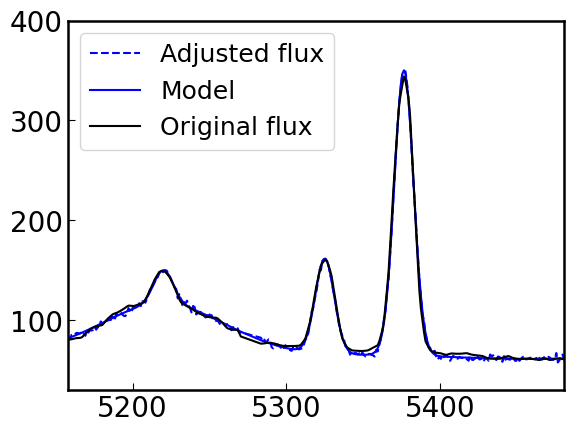

In [524]:
plt.plot(lam, adjusted_flux, color='blue', linestyle='--', label='Adjusted flux')
plt.plot(lam, model, color='blue', label='Model')
plt.plot(lam, flux, color = 'black', label='Original flux')
plt.legend()
plt.xlim(4800*(1+z), 5100*(1+z))
plt.ylim(30, 400)
plt.show()

In [297]:
dataframes

{'Fit_0':                      fwhm        sigma          ew         peak          area  \
 Ha_br         4491.472275  1881.834682  238.277256  6558.783214  14229.810460   
 Ha_na          624.052241   261.311866   32.945978  6558.180485   1967.218126   
 NII6549        787.162071   329.682069    5.854161  6543.430534    349.221301   
 NII6585        787.162289   329.682160   17.616366  6578.827316   1053.331255   
 SII6718        787.162133   329.682094    5.565126  6711.705913    336.098493   
 SII6732        787.162146   329.682100    5.570346  6726.071818    336.817886   
 OI6300         787.753375   329.929721    4.232880  6298.852875    249.404790   
 HeI5875_br   14106.616138  5913.191301   43.710362  5869.863584   2564.240466   
 HeI5875_na     787.162367   329.682193    2.440739  5869.863584    143.055873   
 Hb_br         5419.435676  2270.507497   74.735616  4856.193861   5036.540240   
 Hb_na          872.660451   364.286004    8.305196  4857.333953    559.356696   
 OIII49

In [296]:
dataframes['Fit_3']

,fwhm,sigma,ew,peak,area,snr
Ha_br,4454.740358,1866.214937,242.723525,6557.365826,14437.664922,31.900667
Ha_na,639.902954,267.949111,33.995021,6558.116693,2021.827406,19.159626
NII6549,824.785266,344.124112,5.568308,6542.578355,330.848835,2.572571
NII6585,824.785494,344.124208,16.755257,6577.970527,997.915699,6.979583
SII6718,824.785331,344.124140,5.375723,6710.831819,323.532645,1.684037
SII6732,824.785345,344.124145,5.380374,6725.195853,324.225142,1.628939
OI6300,825.461764,344.406367,4.519970,6298.466959,265.341778,2.392563
HeI5875_br,14106.478921,5913.133782,43.995820,5869.806487,2578.113863,3.894599
HeI5875_na,824.785577,344.124242,2.564299,5869.099127,150.129720,2.472537
Hb_br,5218.744565,2186.397988,73.305830,4856.150965,4963.806315,10.176883


In [38]:
dataframes['Fit_1'].at['Ha_br', 'sigma']

1925.0437213036157

# Old Residual Bins

In [57]:
# Split spectrum into 100 Angstrum bins to vary residual average over spectrum
bounds = np.arange(int(min(lam)/100)*100 + 100, int(max(lam)/100)*100 + 200, 100) # create 100 Angstrom bins covering the range of lam upper lims (4000-7500)
residual_means = []
residual_std = []
lower_bound_index = 0
bounds_index = []
for b in range(len(bounds)): # loop through boundaries
    upper_bound_index = bisect.bisect_right(lam, bounds[b]) # finds index of each boundary (pointing right)
    bounds_index.append(upper_bound_index) # stores list of all boundary indexes
    
    residual_means.append(np.mean(residuals[lower_bound_index:upper_bound_index])) # append residual mean from current 100A region
    residual_std.append(np.std(residuals[lower_bound_index:upper_bound_index])) # append std dev of residuals from current 100A region
    
    lower_bound_index = upper_bound_index # adjust new lower bound up



# Another old residual bins method
# Convert conti_windows into an array and undo the rest frame correction
conti_windows_array = np.array(conti_windows.tolist())
conti_windows_uncorrected = conti_windows_array*(1+z)

# Split spectrum into bins to vary residual average based on proximity to continuum bins
bounds = [] # midpoints between conti_windows to control noise used to adjust flux
bounds_index = []
conti_window_index = [] # indexes marking which points lay within the conti_windows selected
residual_means = []
residual_std = []
for i in range(len(conti_windows_uncorrected)): # loop through continuum windows and set the boundaries between windows to be halfway between 
    if i < len(conti_windows_uncorrected)-1:
        bounds.append((conti_windows_uncorrected[i][1]+conti_windows_uncorrected[i+1][0])/2) # set bounds wavelength to be midpoints between conti_windows
    else:
        bounds.append(lam[-1]+1) # set final boundary wavelength to be to the right of the final lam value

for b in range(len(bounds)): # loop through boundaries between conti_windows
    lower_bound_index = bisect.bisect_left(lam, conti_windows_uncorrected[b][0])
    upper_bound_index = bisect.bisect_right(lam, conti_windows_uncorrected[b][1]) # finds index of conti_windows
    conti_window_index.append([lower_bound_index, upper_bound_index]) # stores list of all boundary indexes
    
    residual_means.append(np.mean(residuals[conti_window_index[b][0]:conti_window_index[b][1]])) # calculate residual mean and std of flux within the conti_window indexes of the flux data
    residual_std.append(np.std(residuals[conti_window_index[b][0]:conti_window_index[b][1]]))
    
    bounds_index.append(bisect.bisect_right(lam, bounds[b])) # create list of bounds indexes

print('Residual Std Dev')
print(residual_std)

Residual Std Dev
[7.074250202673758, 6.59607950925503, 4.683889551679783, 3.6052538139244903, 4.10358796516899, 3.9447475437852346, 1.6842829797356915, 3.032271498075345, 2.1370571840475785]


# Old Dataframe Creation

In [ ]:
# DataFrame structure
index = ['Ha_br', 'Ha_na', 'NII6549', 'NII6585', 'SII6718', 'SII6732', 'OI6300', 'HeI5875_br', 'HeI5875_na', 'Hb_br', 'Hb_na', 'OIII4959c', 'OIII5007c', 'HeII4687_br', 'HeII4687_na', 'Hg_br', 'Hd_br', 'Hep_br', 'Hep_na', 'NeIII3868', 'OII3728']

# Dictionary to store DataFrames
dataframes = {}

# Loop to fit spectra
for i in range(5):
    
    '''
    # Alter initial line priors
    adjusted_line_priors = line_priors # create copy of line_priors to be altered
    for l in range(len(line_priors)): # loop over each line
        # Change initial scale
        adjusted_line_priors[l][6] = r.gauss(mu = line_priors[l][6], sigma = 0.1*line_priors[l][6]) # gaussian distribution centered on original val, sigma of 10%
        # Change initial sigma
        adjusted_line_priors[l][9] = r.gauss(mu = line_priors[l][9], sigma = 0.1*line_priors[l][9])
    
    # Save line info
    hdu1 = fits.BinTableHDU(data=adjusted_line_priors, header=hdr1, name='line_priors')
    
    hdu_list = fits.HDUList([primary_hdu, hdu1, hdu2, hdu3, hdu4])
    hdu_list.writeto(os.path.join(path_ex, 'qsopar.fits'), overwrite=True)
    '''
    
    # Resample spectra to simulate different noise
    bin = 0 # wavelength bin
    adjusted_flux = np.zeros_like(flux)
    for f in range(len(adjusted_flux)):
        
        # Loop to find which bin 
        wav_bin_found = False
        while wav_bin_found == False:
            if f < bounds_index[bin]: # is this flux value in current 100A wav bin
                resid_sigma = residual_std[bin]
                wav_bin_found = True
            else:
                bin += 1 # increment to next wavelength bin
        
        adjusted_flux[f] = r.gauss(mu = model_flux_22[f], sigma = resid_sigma) # gaussian distribution centered on original spectra flux with sigma of residual s.d.
    
    # Run fitting
    q_mcmc = QSOFit(lam, adjusted_flux, err, z, ra=ra, dec=dec, path=path_ex)
    
    start = timeit.default_timer()

    q_mcmc.Fit(name='J02454549-0304496, Sample Test, 2022', nsmooth=1, deredden=False, reject_badpix=False, wave_range=None, \
               wave_mask=None, decompose_host=False, host_prior=False, host_prior_scale=0.1, decomp_na_mask=True, npca_gal=5, host_type='PCA', npca_qso=10, \
               qso_type='DZBIN1', Fe_uv_op=True, poly=True, rej_abs_conti=False, rej_abs_line=True, MCMC=False, nsamp=400, linefit=True, \
               plot_fig=False, save_fig=False, save_result=False, plot_corner=False, kwargs_plot={'save_fig_path': '.'}, save_fits_name=None, verbose=False)
    
    end = timeit.default_timer()
                    
    print(f'Fit_{i} finished in {np.round(end - start, 1)}s')
    
    # Create empty parameter lists
    fwhm_list = []
    sigma_list = []
    ew_list = []
    peak_list = []
    area_list = []
    snr_list = []
    
    for j in range(len(index)): # for each fit line
        fwhm, sigma, ew, peak, area, snr = q_mcmc.line_prop_from_name(line_name[j], line_type[j])
        fwhm_list.append(fwhm)
        sigma_list.append(sigma)
        ew_list.append(ew)
        peak_list.append(peak)
        area_list.append(area)
        snr_list.append(snr)
    
    # Create DataFrame using a dictionary (column-wise)
    df = pd.DataFrame({
        "fwhm": fwhm_list,
        "sigma": sigma_list,
        "ew": ew_list,
        "peak": peak_list,
        "area": area_list,
        "snr": snr_list
    }, index=index)  # Assign row labels
    
    dataframes[f"Fit_{i}"] = df  # Store with a key